In [ ]:
!nvidia-smi

Thu Mar 20 11:35:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.3 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HkW4tkY2Mm1aULGOiBEk")
project = rf.workspace("object-detection-attemp1").project("my-first-project-htrgh")
version = project.version(3)
dataset = version.download("yolov12")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-3 in yolov12:: 100%|██████████| 1970/1970 [00:01<00:00, 1615.24it/s]


In [ ]:
from ultralytics import YOLO
from roboflow import Roboflow
import torch
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [ ]:
dataset_path = "/content/My-First-Project-3"  # Adjust based on output folder name
data_yaml = f"{dataset_path}/data.yaml"


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Sync CUDA errors
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("Fixing class IDs...")
class_mapping = {1: 0, 8: 1, 3: 2}  # Map: 1->BUS(0), 8->People(1), 3->car(2)
for split in ['train', 'valid', 'test']:
    label_dir = f"{dataset_path}/{split}/labels"
    if not os.path.exists(label_dir):
        continue
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            file_path = os.path.join(label_dir, label_file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
            with open(file_path, 'w') as f:
                for line in lines:
                    if line.strip():
                        class_id = int(line.split()[0])
                        if class_id in class_mapping:
                            new_id = class_mapping[class_id]
                            f.write(f"{new_id} {' '.join(line.split()[1:])}\n")
                        elif class_id in [0, 1, 2]:
                            f.write(line)  # Already correct
                        else:
                            print(f"Removed invalid class {class_id} in {split}/{label_file}")

# Step 6: Load YOLOv11m model
model = YOLO('yolo11m.pt')  # Fresh start; or load best.pt if preferred

# Step 7: Train with precision-focused parameters
model.train(
    data=data_yaml,
    epochs=100,
    imgsz=640,
    batch=16,
    device=0,
    patience=0,             # Train fully
    name='yolo11m',
    project='/content/drive/MyDrive/yolo11_result',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.0001,
    lrf=0.01,
    box=10.0,               # Emphasize box accuracy
    cls=3.0,                # Heavily penalize misclassifications
    dfl=2.0,
    conf=0.5,               # Higher confidence threshold
    iou=0.7,                # Stricter NMS
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5,
    degrees=15.0,
    translate=0.2,
    scale=1.0,
    shear=5.0,
    mosaic=1.0,             # Full-strength mosaic for robustness
    mixup=0.7,              # Stronger mixup to reduce false positives
    copy_paste=0.5,         # Encourage focus on true objects
    augment=True
)

Fixing class IDs...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/My-First-Project-3/data.yaml, epochs=100, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/yolo11_result, name=yolo11m, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.5, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

train: Scanning /content/My-First-Project-3/train/labels.cache... 784 images, 12 backgrounds, 0 corrupt: 100%|██████████| 784/784 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/My-First-Project-3/valid/labels.cache... 125 images, 1 backgrounds, 0 corrupt: 100%|██████████| 125/125 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/yolo11_result/yolo11m/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/yolo11_result/yolo11m
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.3G      2.318      11.85      1.961        312        640: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.311      0.247      0.275      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      10.3G      2.045      6.775      1.744        220        640: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        125        806      0.823      0.532      0.698      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.3G      1.974      6.446      1.716        223        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        125        806      0.842      0.582      0.738      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      10.3G      1.926      5.992      1.682        429        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        125        806       0.85      0.614      0.747      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      10.3G      1.883      5.769      1.651        420        640: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        125        806      0.803      0.502      0.663      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      10.3G      1.914      5.772      1.686        313        640: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        125        806      0.862      0.551       0.73       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.3G      1.874      5.611      1.656        242        640: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        125        806      0.839       0.51      0.676      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.3G      1.854      5.496       1.64        177        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        125        806        0.9      0.602      0.768      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.3G      1.836      5.384      1.643        337        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        125        806      0.901      0.544      0.734      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      10.3G      1.848      5.372      1.635        390        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.846      0.616      0.744      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.3G       1.82      5.315      1.608        398        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.822       0.64      0.772      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.3G      1.826      5.188      1.624        277        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806       0.88      0.686      0.805      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      10.3G      1.802      5.188      1.624        229        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.874      0.653      0.759      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      10.3G      1.792      5.076      1.612        392        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        125        806      0.863      0.598      0.755      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.3G        1.8      5.097      1.599        401        640: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        125        806      0.939        0.6      0.782      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      10.3G      1.765      5.017      1.586        283        640: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        125        806      0.929      0.571      0.762      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.3G       1.77      4.992      1.601        509        640: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        125        806      0.895      0.646      0.794      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.3G      1.765      4.894      1.592        299        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.885       0.65      0.788      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.3G      1.764      4.852      1.576        336        640: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.906      0.676      0.807      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.3G      1.731      4.815      1.578        339        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.926      0.659      0.801      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.3G      1.755      4.813      1.575        467        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        125        806      0.917       0.58      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.3G      1.718      4.663      1.563        404        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.882      0.667      0.796      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.3G      1.752      4.852      1.595        347        640: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.883      0.633      0.775      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.3G      1.706      4.735      1.587        273        640: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        125        806      0.811      0.669      0.773      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.3G      1.695      4.732      1.568        331        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        125        806      0.806      0.679      0.755      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.3G       1.68      4.531      1.544        255        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        125        806      0.865      0.669      0.794      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.3G      1.722      4.675      1.557        278        640: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        125        806      0.852      0.691      0.787      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.3G      1.684      4.552      1.553        315        640: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        125        806      0.881      0.672      0.803       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      10.3G      1.695      4.515      1.555        323        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        125        806      0.839      0.675      0.769      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      10.3G      1.646      4.406       1.53        289        640: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        125        806      0.915      0.642      0.794      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.3G      1.695      4.521      1.548        268        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        125        806      0.898      0.643      0.791      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      10.3G       1.66      4.448      1.546        322        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        125        806       0.83      0.629      0.763       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      10.3G      1.681      4.421      1.546        369        640: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        125        806      0.818       0.66      0.762      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.3G      1.686      4.476      1.539        269        640: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.895      0.642      0.791      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.3G      1.676      4.462      1.537        298        640: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        125        806      0.865      0.672      0.791      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      10.3G      1.673      4.374      1.542        315        640: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        125        806      0.908      0.662      0.804      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      10.3G      1.646      4.335      1.526        257        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        125        806      0.926      0.586      0.772       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.3G      1.673      4.459      1.543        326        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        125        806      0.835      0.664      0.774      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      10.3G      1.648      4.368      1.539        369        640: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        125        806      0.896      0.671      0.803       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.3G      1.617      4.202      1.514        237        640: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        125        806      0.927      0.654      0.804      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      10.3G      1.636      4.305      1.536        323        640: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        125        806      0.902      0.684      0.811      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      10.3G      1.634       4.32      1.543        305        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        125        806      0.905      0.688       0.81      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.3G      1.628      4.269      1.522        279        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        125        806      0.874      0.716      0.821      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      10.3G      1.614      4.271      1.519        219        640: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.898      0.757      0.843      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      10.3G       1.62      4.212      1.518        278        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        125        806       0.91      0.678       0.81       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.3G      1.603      4.141      1.495        236        640: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        125        806      0.926      0.654      0.798      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.3G       1.62      4.218      1.525        305        640: 100%|██████████| 49/49 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        125        806      0.879      0.708       0.82      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.3G      1.609        4.1      1.497        365        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        125        806      0.921       0.66      0.804      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      10.3G      1.607      4.138      1.512        243        640: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        125        806      0.906      0.627      0.781      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      10.3G       1.59      4.099      1.492        243        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        125        806      0.908      0.594      0.766      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.3G      1.593      4.095      1.496        234        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        125        806      0.902      0.677      0.807      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      10.3G      1.578      4.061      1.503        392        640: 100%|██████████| 49/49 [00:39<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        125        806       0.91      0.688      0.816      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      10.3G      1.598      4.001      1.493        343        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.907      0.639       0.78      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.3G      1.576      3.991      1.479        363        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.918      0.692      0.815      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      10.3G      1.564      3.916      1.477        274        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.884      0.663      0.794      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      10.3G      1.569      3.982      1.481        229        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.871      0.662      0.785      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.3G      1.573      4.022        1.5        210        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.903      0.669      0.798      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      10.3G      1.584      4.076      1.522        400        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.893      0.697      0.811      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.3G      1.602       4.05      1.505        363        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.907      0.671      0.798      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.3G      1.602      4.053      1.493        359        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        125        806        0.9      0.681        0.8      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.3G      1.569      3.935      1.481        263        640: 100%|██████████| 49/49 [00:39<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        125        806      0.918      0.711      0.822      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      10.3G      1.565      3.925      1.489        354        640: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        125        806       0.92        0.7       0.82       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.3G       1.56      3.848      1.476        215        640: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.904       0.65      0.788      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.3G      1.576      3.902      1.485        250        640: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.912      0.644      0.795      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.3G      1.566      3.958      1.491        275        640: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.859      0.685      0.789      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.3G      1.553      3.887      1.479        219        640: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.889      0.668      0.791       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.3G      1.543      3.868      1.478        290        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        125        806      0.875      0.649      0.778      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.3G      1.517      3.771      1.462        263        640: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        125        806      0.877      0.643       0.78      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.3G      1.503      3.759       1.46        282        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        125        806      0.907      0.671      0.801      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.3G      1.554      3.848      1.479        350        640: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        125        806      0.904      0.676      0.805      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.3G      1.541      3.869      1.475        194        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.941      0.684      0.822      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.3G      1.538      3.783      1.457        367        640: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.906      0.682      0.809      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.3G      1.525      3.782       1.47        227        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.921      0.692      0.822      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.3G      1.533      3.798      1.473        312        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.903      0.688      0.817       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.3G      1.501      3.664      1.451        283        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.913        0.7      0.822      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.3G      1.522      3.756      1.463        360        640: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.909      0.722      0.832      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.3G      1.513      3.733      1.474        494        640: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.915      0.689      0.823       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.3G      1.501      3.694      1.457        525        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.911      0.718      0.835      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.3G      1.492       3.66      1.438        338        640: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.915      0.712      0.829      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.3G        1.5      3.759      1.454        258        640: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        125        806      0.929      0.716      0.833      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      10.3G      1.504      3.691      1.447        269        640: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        125        806      0.924      0.708      0.833      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      10.3G      1.518      3.748      1.458        209        640: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        125        806      0.935       0.73      0.845      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      10.3G      1.479      3.619      1.447        327        640: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.909      0.702      0.824      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      10.3G      1.512      3.661      1.464        237        640: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.936      0.696      0.828      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      10.3G      1.497      3.676      1.455        345        640: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        125        806       0.91      0.732      0.839      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      10.3G      1.482       3.66      1.457        278        640: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.934      0.719      0.837      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      10.3G      1.496      3.688      1.457        260        640: 100%|██████████| 49/49 [00:39<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        125        806      0.936      0.697      0.827      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      10.3G      1.498      3.719      1.464        267        640: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        125        806       0.94      0.709      0.835      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      10.3G      1.511       3.73      1.468        322        640: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        125        806      0.932      0.714      0.837      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      10.3G      1.487      3.625      1.444        479        640: 100%|██████████| 49/49 [00:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        125        806      0.933       0.69      0.825      0.569


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      10.3G       1.36      3.211      1.448         52        640: 100%|██████████| 49/49 [00:37<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        125        806      0.927      0.694      0.822      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      10.3G      1.345      2.959      1.439        104        640: 100%|██████████| 49/49 [00:36<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        125        806      0.908      0.673       0.81      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.3G      1.314      2.848      1.419         94        640: 100%|██████████| 49/49 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        125        806      0.929      0.672      0.814      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      10.3G      1.328      2.785      1.438        116        640: 100%|██████████| 49/49 [00:36<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

                   all        125        806      0.932      0.701      0.829      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      10.3G      1.314      2.759      1.423         55        640: 100%|██████████| 49/49 [00:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        125        806      0.929      0.701      0.828      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      10.3G      1.299      2.782      1.418        101        640: 100%|██████████| 49/49 [00:36<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        125        806      0.929      0.702      0.828      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      10.3G      1.291      2.769      1.421         78        640: 100%|██████████| 49/49 [00:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.931      0.703      0.831      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      10.3G      1.299      2.738        1.4        143        640: 100%|██████████| 49/49 [00:37<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        125        806      0.938      0.692      0.827      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.3G      1.301      2.742      1.415         77        640: 100%|██████████| 49/49 [00:37<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        125        806      0.937      0.693      0.827      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      10.3G      1.286      2.686      1.409        116        640: 100%|██████████| 49/49 [00:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        125        806      0.937      0.692      0.828      0.576



100 epochs completed in 1.239 hours.
Optimizer stripped from /content/drive/MyDrive/yolo11_result/yolo11m/weights/last.pt, 40.5MB
Optimizer stripped from /content/drive/MyDrive/yolo11_result/yolo11m/weights/best.pt, 40.5MB

Validating /content/drive/MyDrive/yolo11_result/yolo11m/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


                   all        125        806       0.86      0.747       0.84      0.573
                     1         17         34      0.846      0.647      0.781      0.486
                     3        124        772      0.874      0.847      0.899       0.66
Speed: 0.4ms preprocess, 48.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/MyDrive/yolo11_result/yolo11m


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d730dba2b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804


0: 384x640 2 cars, 70.2ms
Speed: 2.5ms preprocess, 70.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


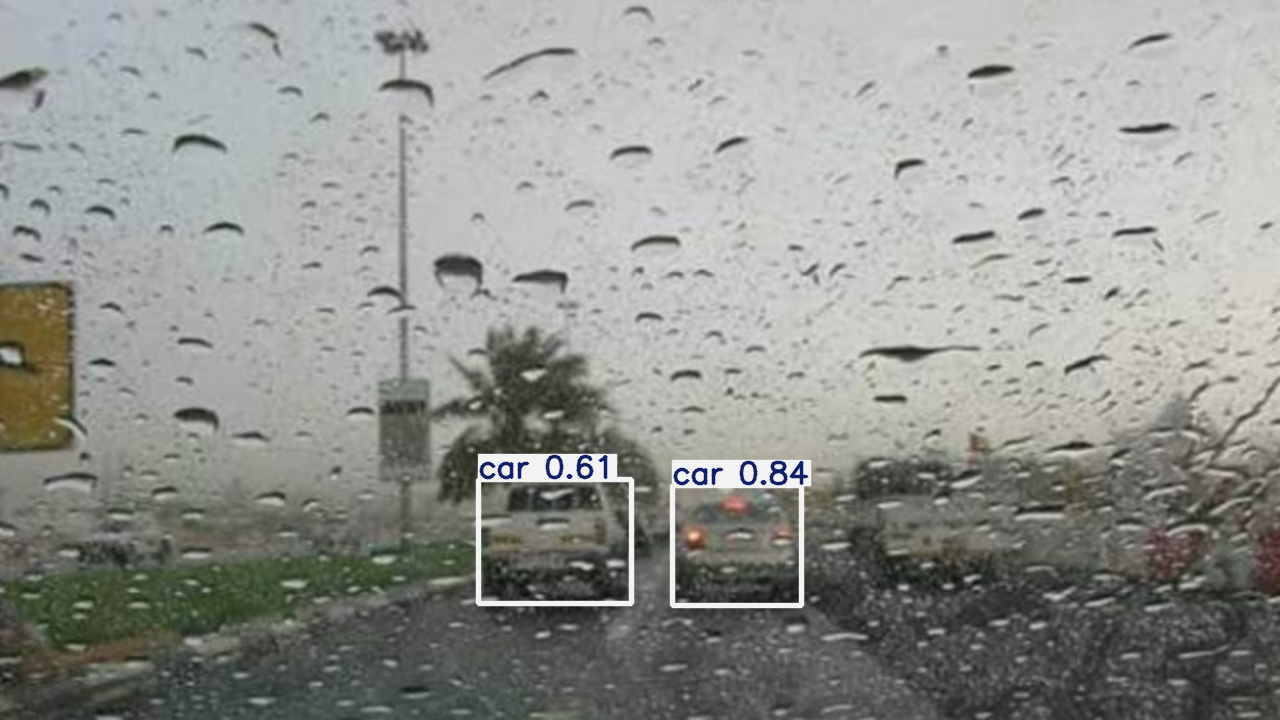

Detected class: car, Confidence: 0.84, Box: tensor([672.7867, 485.8663, 801.8745, 605.5936], device='cuda:0')
Detected class: car, Confidence: 0.61, Box: tensor([478.3971, 479.6228, 631.7128, 603.5587], device='cuda:0')


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained YOLOv11m model
model = YOLO('/content/drive/MyDrive/yolo11_result/yolo11m/yolo11m.pt')  # Path to your model weights

# Load your image
image_path = '/content/rain_storm-213.jpg'  # Path to your image
image = cv2.imread(image_path)

# Run inference
results = model.predict(image, conf=0.5, iou=0.5)  # Returns a list of Results objects

# Access the first Results object (since we only have one image)
result = results[0]  # Get the first (and only) result

# Display the results
result.show()  # Now this should work

# Optionally, print the detected objects
for box, label, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
    print(f"Detected class: {result.names[int(label)]}, Confidence: {conf:.2f}, Box: {box}")


0: 448x640 12 cars, 1 truck, 83.0ms
Speed: 3.8ms preprocess, 83.0ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


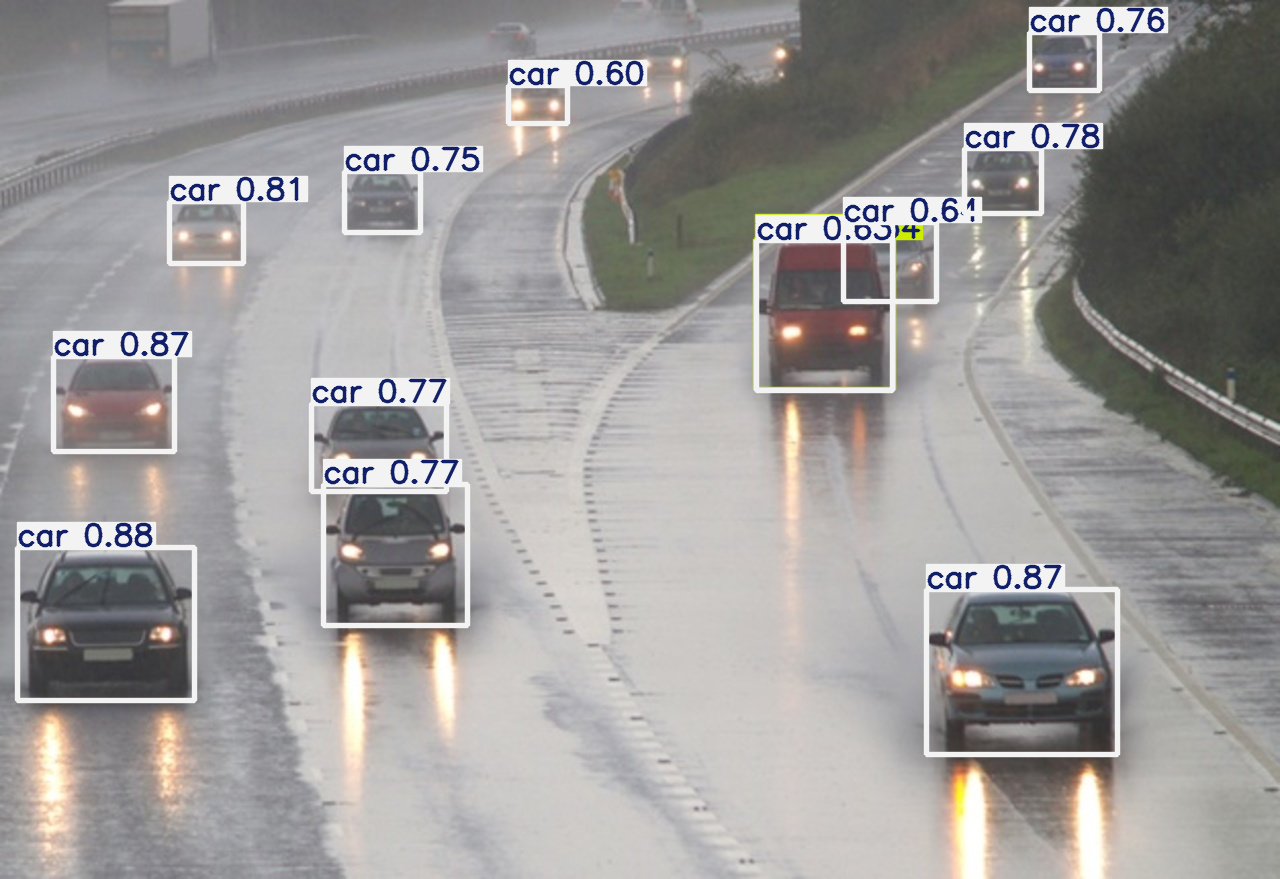

Detected class: car, Confidence: 0.88, Box: tensor([ 17.5348, 547.9389, 194.2327, 700.0338], device='cuda:0')
Detected class: car, Confidence: 0.87, Box: tensor([ 926.3640,  589.4880, 1117.8982,  754.6829], device='cuda:0')
Detected class: car, Confidence: 0.87, Box: tensor([ 53.1203, 356.9053, 174.1759, 451.8099], device='cuda:0')
Detected class: car, Confidence: 0.81, Box: tensor([169.4799, 201.3428, 243.4858, 263.4036], device='cuda:0')
Detected class: car, Confidence: 0.78, Box: tensor([ 964.0392,  148.5643, 1041.5100,  213.6626], device='cuda:0')
Detected class: car, Confidence: 0.77, Box: tensor([323.1355, 484.6458, 467.9088, 625.8571], device='cuda:0')
Detected class: car, Confidence: 0.77, Box: tensor([311.6040, 403.3932, 446.0090, 491.9429], device='cuda:0')
Detected class: car, Confidence: 0.76, Box: tensor([1029.5396,   32.7057, 1099.1997,   90.4918], device='cuda:0')
Detected class: car, Confidence: 0.75, Box: tensor([344.0412, 171.6437, 420.6187, 232.3060], device='cuda:0'

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained YOLOv11m model
model = YOLO('/content/drive/MyDrive/yolo11_result/yolo11m/yolo11m.pt')  # Path to your model weights

# Load your image
image_path = '/content/rain_storm-090.jpg'  # Path to your image
image = cv2.imread(image_path)

# Run inference
results = model.predict(image, conf=0.5, iou=0.5)  # Returns a list of Results objects

# Access the first Results object (since we only have one image)
result = results[0]  # Get the first (and only) result

# Display the results
result.show()  # Now this should work

# Optionally, print the detected objects
for box, label, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
    print(f"Detected class: {result.names[int(label)]}, Confidence: {conf:.2f}, Box: {box}")


0: 384x640 4 persons, 1 bicycle, 2 cars, 1 bus, 3 traffic lights, 41.9ms
Speed: 2.5ms preprocess, 41.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


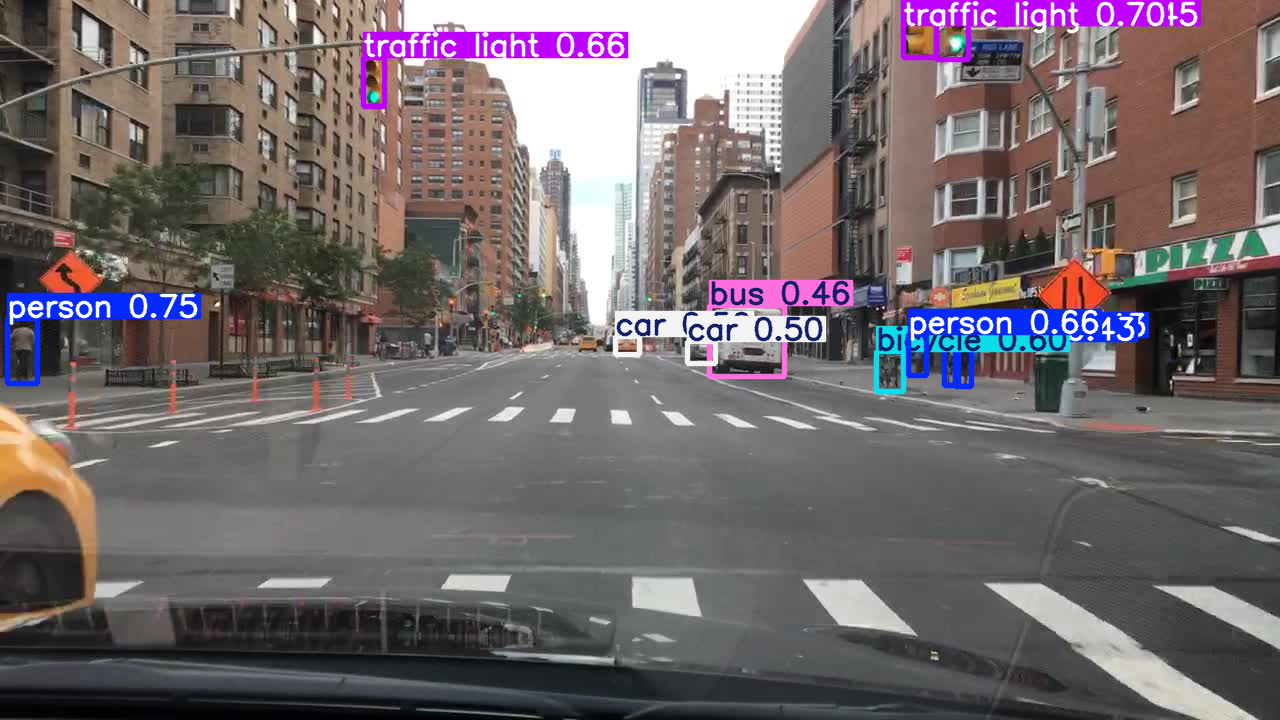

Detected class: person, Confidence: 0.75, Box: tensor([  7.4455, 318.4566,  37.7775, 383.0901], device='cuda:0')
Detected class: traffic light, Confidence: 0.70, Box: tensor([903.2649,   0.0000, 936.7480,  57.6848], device='cuda:0')
Detected class: traffic light, Confidence: 0.66, Box: tensor([363.2832,  57.6449, 384.4392, 106.4373], device='cuda:0')
Detected class: person, Confidence: 0.66, Box: tensor([908.9776, 334.9898, 926.8942, 375.3084], device='cuda:0')
Detected class: bicycle, Confidence: 0.60, Box: tensor([876.5854, 351.9680, 903.4150, 391.5880], device='cuda:0')
Detected class: car, Confidence: 0.50, Box: tensor([687.2955, 341.4377, 715.8099, 363.2162], device='cuda:0')
Detected class: car, Confidence: 0.50, Box: tensor([615.8246, 336.2888, 639.5692, 354.2842], device='cuda:0')
Detected class: bus, Confidence: 0.46, Box: tensor([709.6340, 305.9460, 784.5439, 376.3094], device='cuda:0')
Detected class: traffic light, Confidence: 0.45, Box: tensor([9.3651e+02, 4.5204e-01, 9.68

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained YOLOv11m model
model = YOLO('/content/drive/MyDrive/yolo11_result/yolo11m/yolo11m.pt')  # Path to your model weights

# Load your image
image_path = '/content/fe189115-354e7981.jpg'  # Path to your image
image = cv2.imread(image_path)

# Run inference
results = model.predict(image, conf=0.40, iou=0.5)  # Returns a list of Results objects

# Access the first Results object (since we only have one image)
result = results[0]  # Get the first (and only) result

# Display the results
result.show()  # Now this should work

# Optionally, print the detected objects
for box, label, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
    print(f"Detected class: {result.names[int(label)]}, Confidence: {conf:.2f}, Box: {box}")


0: 384x640 5 cars, 1 truck, 42.5ms
Speed: 1.9ms preprocess, 42.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


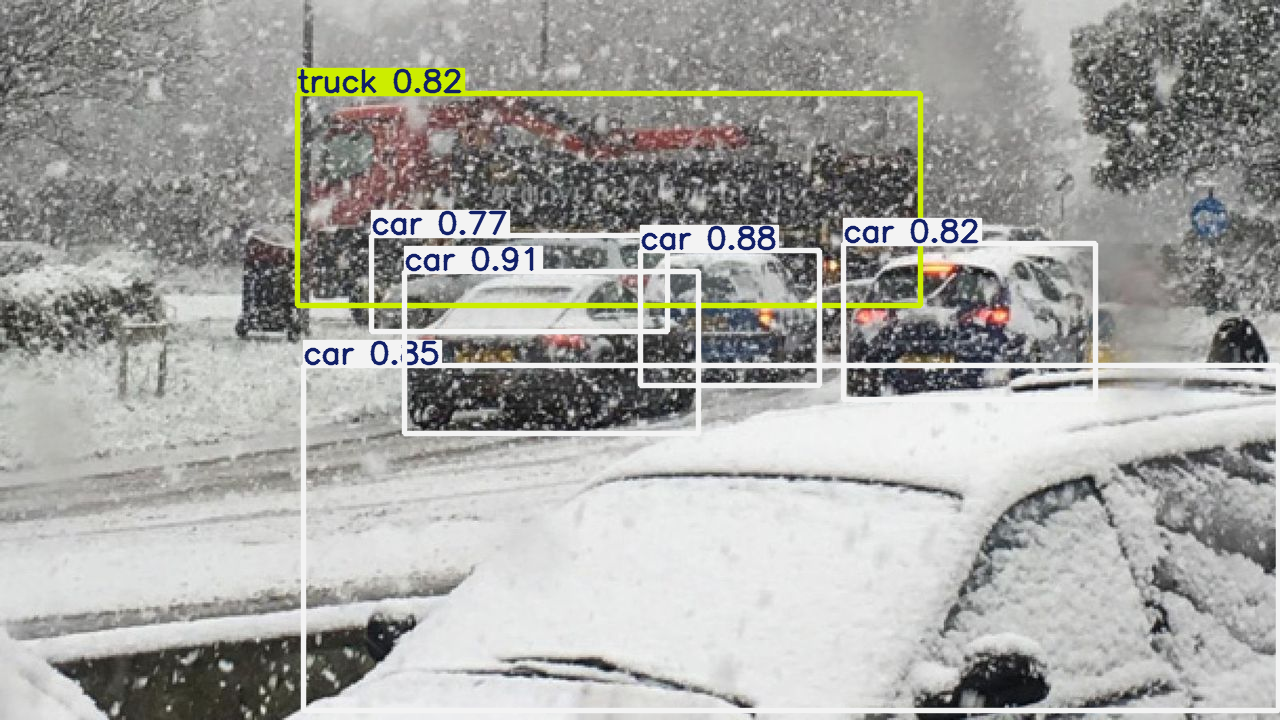

Detected class: car, Confidence: 0.91, Box: tensor([404.3629, 271.2496, 698.6852, 433.0705], device='cuda:0')
Detected class: car, Confidence: 0.88, Box: tensor([640.1119, 250.9267, 819.5856, 385.3522], device='cuda:0')
Detected class: car, Confidence: 0.85, Box: tensor([ 303.0267,  365.2268, 1278.4650,  710.0020], device='cuda:0')
Detected class: car, Confidence: 0.82, Box: tensor([ 843.5996,  243.2739, 1095.0011,  399.2639], device='cuda:0')
Detected class: truck, Confidence: 0.82, Box: tensor([297.8514,  93.7613, 920.7335, 305.9628], device='cuda:0')
Detected class: car, Confidence: 0.77, Box: tensor([371.6638, 235.5038, 667.3707, 331.2221], device='cuda:0')


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained YOLOv11m model
model = YOLO('/content/drive/MyDrive/yolo11_result/yolo11m/yolo11m.pt')  # Path to your model weights

# Load your image
image_path = '/content/snow_storm-255.jpg'  # Path to your image
image = cv2.imread(image_path)

# Run inference
results = model.predict(image, conf=0.5, iou=0.5)  # Returns a list of Results objects

# Access the first Results object (since we only have one image)
result = results[0]  # Get the first (and only) result

# Display the results
result.show()  # Now this should work

# Optionally, print the detected objects
for box, label, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
    print(f"Detected class: {result.names[int(label)]}, Confidence: {conf:.2f}, Box: {box}")


0: 640x608 2 cars, 1 truck, 46.0ms
Speed: 3.1ms preprocess, 46.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


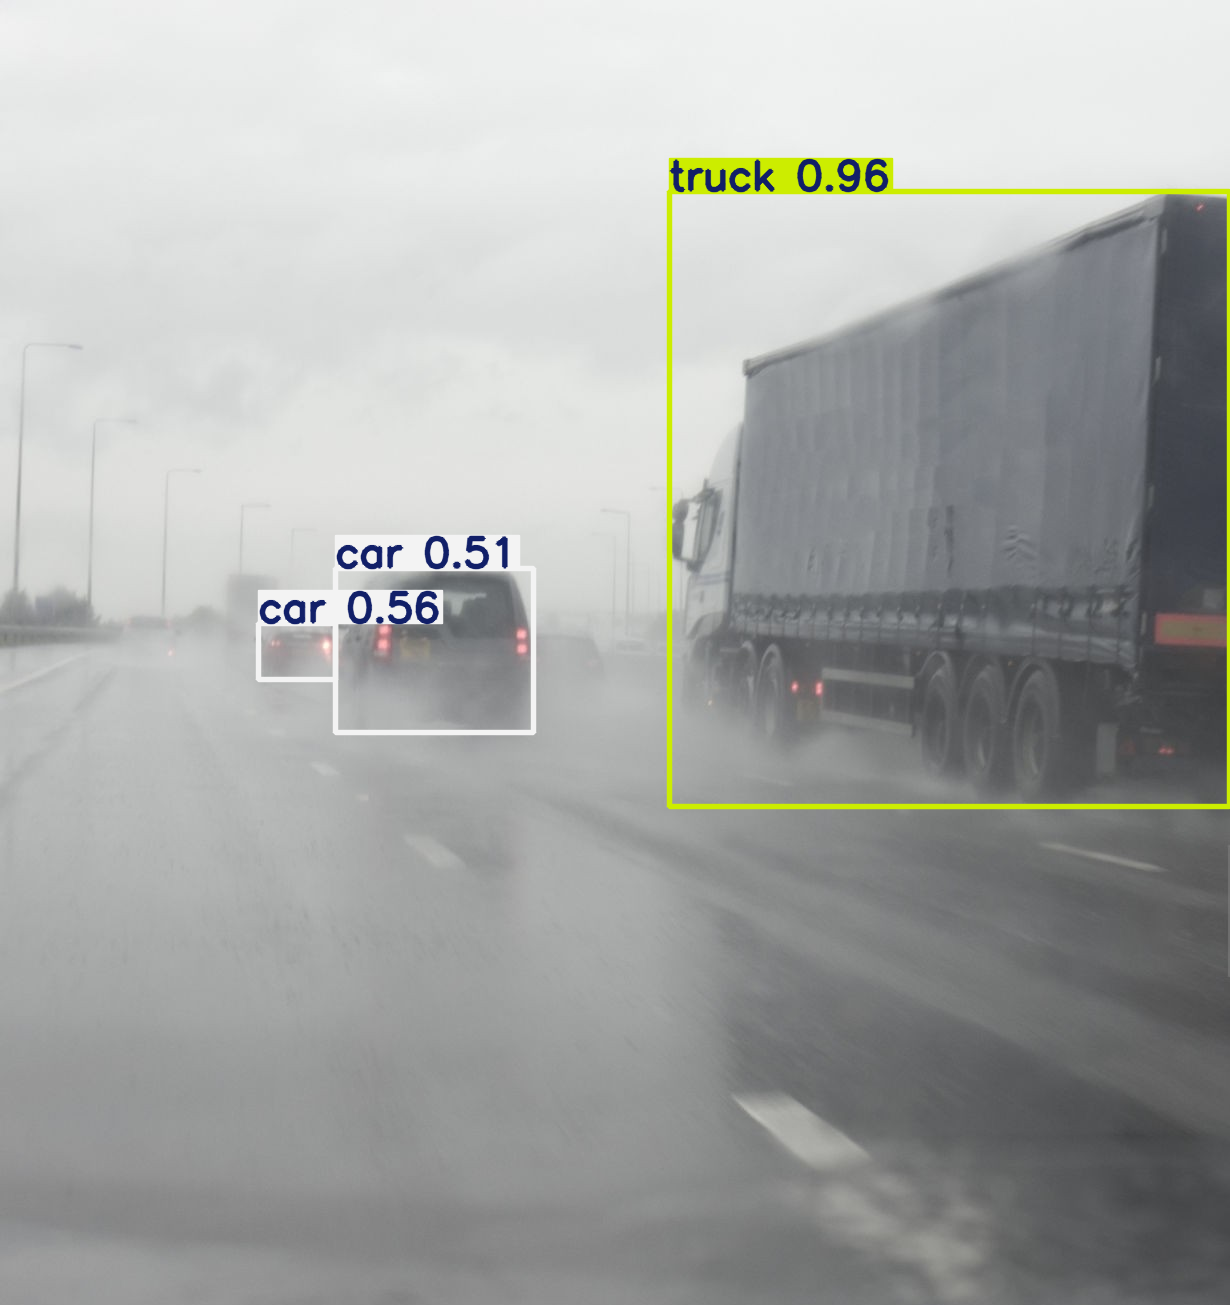

Detected class: truck, Confidence: 0.96, Box: tensor([ 669.1692,  191.7772, 1229.2290,  806.1890], device='cuda:0')
Detected class: car, Confidence: 0.56, Box: tensor([258.2599, 623.8853, 335.9096, 679.0927], device='cuda:0')
Detected class: car, Confidence: 0.51, Box: tensor([335.3647, 568.2814, 533.5770, 732.2164], device='cuda:0')


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained YOLOv11m model
model = YOLO('/content/drive/MyDrive/yolo11_result/yolo11m/yolo11m.pt')  # Path to your model weights

# Load your image
image_path = '/content/mist-114.jpg'  # Path to your image
image = cv2.imread(image_path)

# Run inference
results = model.predict(image, conf=0.5, iou=0.5)  # Returns a list of Results objects

# Access the first Results object (since we only have one image)
result = results[0]  # Get the first (and only) result

# Display the results
result.show()  # Now this should work

# Optionally, print the detected objects
for box, label, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
    print(f"Detected class: {result.names[int(label)]}, Confidence: {conf:.2f}, Box: {box}")

In [ ]:
from ultralytics import YOLO

# Load the trained YOLOv11m model
model = YOLO('/content/drive/MyDrive/yolo11_result/yolo11m/yolo11m.pt')  # Path to your model weights

# Path to your video
video_path = '/content/boreas-2021-04-29-15-55.mp4'  # Replace with the path to your video

# Run inference on the video
results = model.predict(video_path, conf=0.5, iou=0.5, save=True, save_dir='path/to/save/results')

# The output video with detections will be saved in the specified save_dir
print(f"Output video saved in: {results[0].save_dir}")

Streaming output truncated to the last 5000 lines.
video 1/1 (frame 5723/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 33.4ms
video 1/1 (frame 5724/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 32.6ms
video 1/1 (frame 5725/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 34.3ms
video 1/1 (frame 5726/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 41.4ms
video 1/1 (frame 5727/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 33.9ms
video 1/1 (frame 5728/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 33.5ms
video 1/1 (frame 5729/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 33.1ms
video 1/1 (frame 5730/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 33.9ms
video 1/1 (frame 5731/10719) /content/boreas-2021-04-29-15-55.mp4: 544x640 (no detections), 33.8ms
video 1/1 (frame 5732/10719) /content/boreas-2021-04-29-15